In [ ]:
!pip install ipywidgets
!pip install accelerate
!pip install pfrl@git+https://github.com/voidful/pfrl.git
!pip install textrl
#instal nltk
!pip install nltk
!pip install sentencepiece
!pip install evaluate

In [1]:
from DualRLStyleTransfer.load_and_prepare_data import load_dataset_yelp_reviews
import matplotlib.pyplot as plt
import numpy as np


train_data, test_data, dev_data, test_data_and_references = load_dataset_yelp_reviews()

train_negative_to_positive_dataX = []
train_negative_to_positive_dataY = []
train_positive_to_negative_dataX = []
train_positive_to_negative_dataY = []

for i in range(0,4):
    print(test_data_and_references[i])


for i in range(0,len(test_data_and_references)):
    input = test_data_and_references[i]['input']
    label = test_data_and_references[i]['label']
    ref = test_data_and_references[i]['ref']
    for r in ref:
        if label == 'NEGATIVE':
            train_negative_to_positive_dataX.append(input)
            train_negative_to_positive_dataY.append(r)
        else:
            train_positive_to_negative_dataX.append(input)
            train_positive_to_negative_dataY.append(r)

#shuffle data
from sklearn.utils import shuffle
train_negative_to_positive_dataX, train_negative_to_positive_dataY = shuffle(train_negative_to_positive_dataX, train_negative_to_positive_dataY)
train_positive_to_negative_dataX, train_positive_to_negative_dataY = shuffle(train_positive_to_negative_dataX, train_positive_to_negative_dataY)
for i in range(0,5):
    print(train_negative_to_positive_dataX[i],"-->",train_negative_to_positive_dataY[i])

    


./DualRLStyleTransfer/yelp_data/test.0
./DualRLStyleTransfer/yelp_data/test.1
./DualRLStyleTransfer/yelp_data/dev.0
./DualRLStyleTransfer/yelp_data/dev.1
./DualRLStyleTransfer/yelp_data/train.0
./DualRLStyleTransfer/yelp_data/train.1
./DualRLStyleTransfer/yelp_refrence/reference0.0
./DualRLStyleTransfer/yelp_refrence/reference0.1
./DualRLStyleTransfer/yelp_refrence/reference1.0
./DualRLStyleTransfer/yelp_refrence/reference1.1
./DualRLStyleTransfer/yelp_refrence/reference2.0
./DualRLStyleTransfer/yelp_refrence/reference2.1
./DualRLStyleTransfer/yelp_refrence/reference3.0
./DualRLStyleTransfer/yelp_refrence/reference3.1
{'input': "ever since joes has changed hands it's just gotten worse and worse.", 'label': 'NEGATIVE', 'ref': ["ever since joes has changed hands it's gotten better and better.", 'ever since joes has changed hands it`s gotten better and better.', 'since joe changed hands, it has become a better place.', 'ever since joes has changed hands it is getting better']}
{'input': '

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoModelForSequenceClassification, AutoTokenizer
import torch
from DualRLStyleTransfer.bleu_evaluate import *
import time

batch_size = 1
epochs = 15
learning_rate = 1e-5
SKIP_POS_TO_NEG = True

#append training results to file
log_traning_reslts_file = open("./DualRLStyleTransfer/log_traning_reslts_file.txt", "a")
#loag training parameters
log_traning_reslts_file.write("batch_size: "+str(batch_size)+"\n")
log_traning_reslts_file.write("epochs: "+str(epochs)+"\n")
log_traning_reslts_file.write("learning_rate: "+str(learning_rate)+"\n")


tokenizer = T5Tokenizer.from_pretrained("t5-small")
model_pos_to_neg = T5ForConditionalGeneration.from_pretrained("t5-small")
model_pos_to_neg.eval()
model_pos_to_neg.cuda()

model_neg_to_pos = T5ForConditionalGeneration.from_pretrained("t5-small")
model_neg_to_pos.eval()
model_neg_to_pos.cuda()

sentiment_model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity").to('cuda')
tokenizer_sa = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
def get_sentiment(text):
    inputs = tokenizer_sa(text, return_tensors="pt").to('cuda')
    sentiment = sentiment_model(**inputs)[0]
    acc = torch.nn.functional.softmax(sentiment[0], dim=0)
    if sentiment.argmax() == 1:
        return {'input': text, 'label':'POSITIVE', 'score': 1.0 - float(acc[0])}
    return {'input': text, 'label':'NEGATIVE', 'score':float(acc[0])}


#tokenize data and create tensors for input and output
encoding_pos_to_neg = tokenizer(train_positive_to_negative_dataX,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
target_encoding_pos_to_neg = tokenizer(train_positive_to_negative_dataY,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
encoding_neg_to_pos = tokenizer(train_negative_to_positive_dataX,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
target_encoding_neg_to_pos = tokenizer(train_negative_to_positive_dataY,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
print("tokenized data shape")
print(encoding_pos_to_neg['input_ids'].shape)
print(target_encoding_pos_to_neg['input_ids'].shape)
print(encoding_neg_to_pos['input_ids'].shape)
print(target_encoding_neg_to_pos['input_ids'].shape)

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

#prepare arrays for BLEU score
pos_data = []
pos_data_refs = []
neg_data = []
neg_data_refs = []
for i in range(0,len(test_data_and_references)):
    input = test_data_and_references[i]['input']
    label = test_data_and_references[i]['label']
    ref = test_data_and_references[i]['ref']
    if label == 'NEGATIVE':
        neg_data.append(input)
        neg_data_refs.append(ref)
    else:
        pos_data.append(input)
        pos_data_refs.append(ref)

encoding_pos_data = tokenizer(pos_data,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
encoding_neg_data = tokenizer(neg_data,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')

def BELU_evaluate_model(model_sentiment_transfer, encoded_data, data_refs, target_sentiment='POSITIVE'):
    avg_bleu_score = 0
    sentiment_acc = 0
    avg_sentiment_score = 0
    num_of_samples = 0
    for i in range(0,len(encoded_data.input_ids)):
        input_ids, attention_mask = encoded_data.input_ids[i:i+1], encoded_data.attention_mask[i:i+1]
        #output_string = output_strings[i]
        output_string = tokenizer.decode(model_sentiment_transfer.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
        ngrams = output_string.split()
        if len(ngrams) < 2:
            continue #skip short sentences
        num_of_samples += 1
        refrences = []
        for ref in data_refs[i]:
            refrences.append(ref.split())
        bleu_score = sentence_bleu(refrences,ngrams, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method1)
        output_string_sentiment = get_sentiment(output_string)
        sentiment_score = output_string_sentiment['score']
        if output_string_sentiment['label'] == target_sentiment: #if the output is positive rather than negative, then the sentiment score is low and we want to penalize it
            sentiment_acc += 1
        else:
            sentiment_score = 1 - sentiment_score
            
        avg_bleu_score += bleu_score
        avg_sentiment_score += sentiment_score
        #print(pos_data[i],"-->" ,output_string, "score", bleu_score * sentiment_score)
    avg_bleu_score = avg_bleu_score / num_of_samples
    print("avg bleu score", avg_bleu_score, "sentiment acc", sentiment_acc / num_of_samples, "avg sentiment score", avg_sentiment_score / num_of_samples)
    return avg_bleu_score, sentiment_acc / num_of_samples, avg_sentiment_score / num_of_samples

print(len(train_positive_to_negative_dataX))

tokenized data shape
torch.Size([2000, 25])
torch.Size([2000, 30])
torch.Size([2000, 25])
torch.Size([2000, 32])
2000


In [3]:
#train positive to negative model
model_pos_to_neg_traning_results = []
if SKIP_POS_TO_NEG:
    optimizer = torch.optim.Adam(model_pos_to_neg.parameters(), lr=learning_rate)

    train_start_time = time.time()
    for epoch in range(0,epochs):
        
        avrage_loss = 0
        for i in range(0,len(train_positive_to_negative_dataX),batch_size):
            input_ids, attention_mask = encoding_pos_to_neg.input_ids[i:i+batch_size], encoding_pos_to_neg.attention_mask[i:i+batch_size]
            labels = target_encoding_pos_to_neg.input_ids[i:i+batch_size]

            loss = model_pos_to_neg(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            avrage_loss += loss.loss.item()
            loss.loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #if i % 100 == 0:
                #input_string = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                #target_string = tokenizer.decode(labels[0], skip_special_tokens=True)
                #output_string = tokenizer.decode(model_pos_to_neg.generate(input_ids=input_ids[0], attention_mask=attention_mask[0], max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
                #print("loss", loss.loss.item(), "input", input_string, "-->", target_string)
                #

        print("epoch", epoch, "avrage_loss", avrage_loss/len(train_positive_to_negative_dataX))
        model_pos_to_neg_traning_results.append((avrage_loss/len(train_positive_to_negative_dataX),BELU_evaluate_model(model_pos_to_neg, encoding_pos_data, pos_data_refs, target_sentiment='NEGATIVE')))

    train_end_time = time.time()
    log_traning_reslts_file.write("train_positive_to_negative_dataX time: "+str(train_end_time - train_start_time)+"\n")
else:
    model_pos_to_neg = T5ForConditionalGeneration.from_pretrained("DualRLStyleTransfer/models/pos_to_neg").to('cuda')


epoch 0 avrage_loss 1.4922477961927652
avg bleu score 0.5662481330998924 sentiment acc 0.04986149584487535 avg sentiment score 0.05155492923839226
epoch 1 avrage_loss 0.6471021467670798
avg bleu score 0.6600479586408579 sentiment acc 0.5200803212851406 avg sentiment score 0.5205445479203109
epoch 2 avrage_loss 0.5401987357009203
avg bleu score 0.7128551001059646 sentiment acc 0.722 avg sentiment score 0.7244713141430111
epoch 3 avrage_loss 0.489149528471753
avg bleu score 0.7334467269706657 sentiment acc 0.814 avg sentiment score 0.8167548921491834
epoch 4 avrage_loss 0.44917114505544303
avg bleu score 0.7528212050970947 sentiment acc 0.836 avg sentiment score 0.8417140909920854
epoch 5 avrage_loss 0.41495496191829445
avg bleu score 0.7750933211574574 sentiment acc 0.848 avg sentiment score 0.851531649331475
epoch 6 avrage_loss 0.3855451366584748
avg bleu score 0.7898634386075892 sentiment acc 0.864 avg sentiment score 0.8650307228546299
epoch 7 avrage_loss 0.3577108744494617
avg bleu 

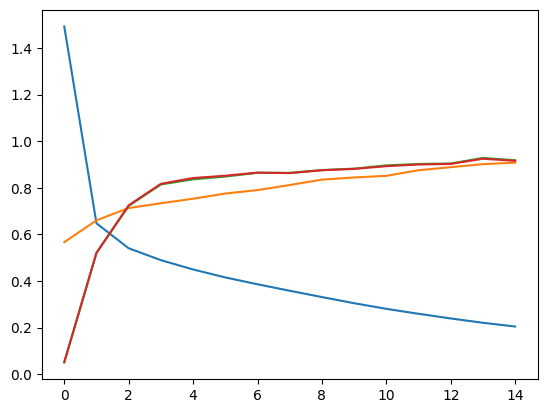

the food is horrible.
the food is not amazing and the service was not great
beautiful views and lots of variety of length and layout of holes
the staff at the restaurant are not pleasant
nothing about this place
is a bad hostess and makes you feel welcome
they do so many things wrong. especially taking care of the customers
the homemade tomato soup with asiago cheese was bland as well


In [19]:
#plot training results
plt.plot([x[0] for x in model_pos_to_neg_traning_results])
plt.plot([x[1] for x in model_pos_to_neg_traning_results])
plt.show()
#demostrate model positive to negative performance on test data
test_data_pos_to_neg = [
    "I love this place. The food is amazing.",
    "I love this place. The food is amazing. The service is great.",
    "beautiful views and lots of variety of length and layout of holes",
    "restaurant personnel are pleasant",
    "i love everything about this place",
    "is a delightful hostess and makes you feel welcome",
    "they do so many things right. especially taking care of the customers",
    "the homemade tomato soup with asiago cheese was delicious as well"
]
encoding_pos_to_neg = tokenizer(test_data_pos_to_neg,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
outputs = model_pos_to_neg.generate(input_ids=encoding_pos_to_neg.input_ids, attention_mask=encoding_pos_to_neg.attention_mask, max_length=150, num_beams=5, early_stopping=True)
for output in outputs:
    print(tokenizer.decode(output, skip_special_tokens=True))

#save data
file_save_traning_data = open("./DualRLStyleTransfer/models/pos_to_neg_traning_data_"+str(epochs)+".csv", "w")
file_save_traning_data.write("loss;bleu_score;sentiment_acc;sentiment_score\n")
for x in model_pos_to_neg_traning_results:
    file_save_traning_data.write(str(x[0])+";"+str(x[1][0])+";"+str(x[1][1])+";"+str(x[1][2])+"\n")
file_save_traning_data.close()

# Evaluating the two models fine-tuned on the parallel data
Note this is not a perfect evaluation as the models were trained on the same data as the test set. However, it is a good indicator of how well the models are doing. The available parallel data is very small so we use all the data when fine-tune the model trained on much larger data set, hoping that the model will learn to generalize well, by taking advantage of the pre-trained weights.
Score is assigned by combining multiple metrics:
- BLEU score of the model's output compared to the reference output. (does the model preserve the content of the input text)
- Accuracy of the sentiment transfer (does the model change the sentiment of the input text correctly).

In [5]:
if SKIP_POS_TO_NEG:
    #calculate bleu scor
    avg_bleu_score = 0
    sentiment_acc = 0
    for i in range(0,len(encoding_pos_data.input_ids)):
        input_ids, attention_mask = encoding_pos_data.input_ids[i:i+1], encoding_pos_data.attention_mask[i:i+1]
        #output_string = output_strings[i]
        output_string = tokenizer.decode(model_pos_to_neg.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
        refrences = []
        for ref in pos_data_refs[i]:
            refrences.append(ref.split())
        bleu_score = sentence_bleu(refrences,output_string.split())
        output_string_sentiment = get_sentiment(output_string)
        sentiment_score = output_string_sentiment['score']
        if output_string_sentiment['label'] == 'POSITIVE': #if the output is positive rather than negative, then the sentiment score is low and we want to penalize it
            sentiment_score = 1 - sentiment_score
            #print("penalizing positive output", output_string, "score", bleu_score * sentiment_score)
        else:
            sentiment_acc += 1
        avg_bleu_score += bleu_score
        #print(pos_data[i],"-->" ,output_string, "score", bleu_score * sentiment_score)
    avg_bleu_score = avg_bleu_score / len(encoding_pos_data.input_ids)
    print("avg bleu score for positive to negative model", avg_bleu_score, "sentiment acc", sentiment_acc / len(encoding_pos_data.input_ids))

    log_traning_reslts_file.write("avg bleu score for positive to negative model: "+str(avg_bleu_score)+"\n")
    log_traning_reslts_file.write("sentiment acc for positive to negative model: "+str(sentiment_acc / len(encoding_pos_data.input_ids))+"\n")

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


avg bleu score for positive to negative model 0.8990743992785218 sentiment acc 0.918


In [6]:
#train negative to positive model
optimizer = torch.optim.Adam(model_neg_to_pos.parameters(), lr=learning_rate)
model_neg_to_pos_traning_results = []
train_start_time = time.time()
for epoch in range(0,epochs):
    avrage_loss = 0
    for i in range(0,len(train_negative_to_positive_dataX),batch_size):
        input_ids, attention_mask = encoding_neg_to_pos.input_ids[i:i+batch_size], encoding_neg_to_pos.attention_mask[i:i+batch_size]
        labels = target_encoding_neg_to_pos.input_ids[i:i+batch_size]

        loss = model_neg_to_pos(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        avrage_loss += loss.loss.item()

        loss.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #if i % 10 == 0:
            
            #input_string = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            #target_string = tokenizer.decode(labels[0], skip_special_tokens=True)
            #output_string = tokenizer.decode(model_neg_to_pos.generate(input_ids=input_ids[0], attention_mask=attention_mask[0], max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
            #print("loss", loss.loss.item(), "input", input_string, "-->", target_string)
            #model_neg_to_pos_traning_results.append(loss.loss.item())
    
    print("epoch", epoch, "loss", avrage_loss / len(train_negative_to_positive_dataX))
    model_neg_to_pos_traning_results.append((avrage_loss/len(train_negative_to_positive_dataX),BELU_evaluate_model(model_neg_to_pos, encoding_neg_data, neg_data_refs, target_sentiment='POSITIVE')))

train_end_time = time.time()
log_traning_reslts_file.write("train_negative_to_positive_dataX time: "+str(train_end_time - train_start_time)+"\n")
    

epoch 0 loss 1.548695517666638
avg bleu score 0.4943457397639189 sentiment acc 0.1694915254237288 avg sentiment score 0.17851940283959514
epoch 1 loss 0.6751175677627325
avg bleu score 0.5141128309462464 sentiment acc 0.2923387096774194 avg sentiment score 0.29604767056970294
epoch 2 loss 0.5897721040099859
avg bleu score 0.5544148523225494 sentiment acc 0.326 avg sentiment score 0.3312616143610212
epoch 3 loss 0.5416878903331235
avg bleu score 0.5816151543616845 sentiment acc 0.36 avg sentiment score 0.3636998088080727
epoch 4 loss 0.5011471428088844
avg bleu score 0.602419841396287 sentiment acc 0.406 avg sentiment score 0.4048643217599601
epoch 5 loss 0.4635580673906952
avg bleu score 0.616058833022285 sentiment acc 0.446 avg sentiment score 0.4464052950996265
epoch 6 loss 0.4274961019158363
avg bleu score 0.6411997277366349 sentiment acc 0.466 avg sentiment score 0.46818853488191964
epoch 7 loss 0.3930668140677735
avg bleu score 0.6688233143336442 sentiment acc 0.492 avg sentiment 

57

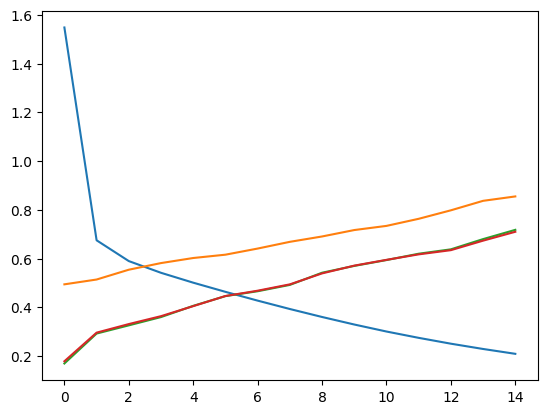

the food is great.
there is no grass on the range
;)
one should buy this place and
very disappointed in the customer service


In [18]:
#plot training results
plt.plot([x[0] for x in model_neg_to_pos_traning_results])
plt.plot([x[1] for x in model_neg_to_pos_traning_results])
plt.show()
#demostrate model negative to positive performance on test data
test_data_neg_to_pos = [
    "I hate this place. The food is terrible.",
    "there is no grass on the range",
    "bottom line , this place sucks",
    "someone should buy this place and turn it into what it should be",
    "very disappointed in the customer service",
]
encoding_neg_to_pos = tokenizer(test_data_neg_to_pos,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
outputs = model_neg_to_pos.generate(input_ids=encoding_neg_to_pos.input_ids, attention_mask=encoding_neg_to_pos.attention_mask, max_length=150, num_beams=5, early_stopping=True)
for output in outputs:
    print(tokenizer.decode(output, skip_special_tokens=True))

#save data
file_save_traning_data = open("./DualRLStyleTransfer/models/neg_to_positive_traning_data_"+str(epochs)+".csv", "w")
file_save_traning_data.write("loss;bleu_score;sentiment_acc;sentiment_score\n")
for x in model_neg_to_pos_traning_results:
    file_save_traning_data.write(str(x[0])+";"+str(x[1][0])+";"+str(x[1][1])+";"+str(x[1][2])+"\n")
file_save_traning_data.close()
    

In [8]:
avg_bleu_score = 0
sentiment_acc = 0
for i in range(0,len(encoding_neg_data.input_ids)):
    input_ids, attention_mask = encoding_neg_data.input_ids[i:i+1], encoding_neg_data.attention_mask[i:i+1]
    #output_string = output_strings[i]
    output_string = tokenizer.decode(model_neg_to_pos.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
    refrences = []
    for ref in neg_data_refs[i]:
        refrences.append(ref.split())
    bleu_score = sentence_bleu(refrences,output_string.split())
    output_string_sentiment = get_sentiment(output_string)
    sentiment_score = output_string_sentiment['score']
    if output_string_sentiment['label'] == 'NEGATIVE': #if the output is positive rather than negative, then the sentiment score is low and we want to penalize it
        sentiment_score = 1 - sentiment_score
        #print("penalizing negative output", output_string, "score", bleu_score * sentiment_score)
    else:
        sentiment_acc += 1
    avg_bleu_score += bleu_score
    print(neg_data[i],"-->" ,output_string, "score", bleu_score * sentiment_score)
avg_bleu_score = avg_bleu_score / len(encoding_neg_data.input_ids)
print("avg bleu score for pos to negative model", avg_bleu_score, "sentiment acc", sentiment_acc / len(encoding_neg_data.input_ids))

log_traning_reslts_file.write("avg bleu score for negative to positive model: "+str(avg_bleu_score)+"\n")
log_traning_reslts_file.write("sentiment acc for negative to positive model: "+str(sentiment_acc / len(encoding_neg_data.input_ids))+"\n")

ever since joes has changed hands it's just gotten worse and worse. --> ever since joes has changed hands it's gotten better and better. score 0.9997002445161343
there is definitely not enough room in that part of the venue. --> there is so much room in that part of the venue score 0.0697755217552185
so basically tasted watered down. --> so basically did not taste watered down. score 0.7480539679527283
she said she'd be back and disappeared for a few minutes. --> she said she'd be back and have a good time score 0.9907815661281347
i ca n't believe how inconsiderate this pharmacy is. --> i can not believe how considerate this pharmacy is. score 0.9782789945602417
just left and took it off the bill. --> just left and put it on the bill. score 0.0001691579818725586
it is n't terrible, but it is n't very good either. --> it isn't terrible, it is very good score 0.20251611840729558
definitely disappointed that i could not use my birthday gift! --> definitely not disappointed that i could us

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


if you travel a lot do not stay at this hotel. --> if you travel a lot stay at this hotel score 0.5812762975692749
i would rather wait for hot food than have it cold and soggy. --> i can get hot food instead of having it cold and soggy. score 0.005689501762390137
the food here is bland and boring and bad. --> the food here is very good. score 0.5063171611139834
this one is not on the ball. --> this one is on the ball score 0.9983488850994036
for the record i am a good cook, i use seasoning! --> for the record i am a good cook, i use seasoning! score 0.44995461698493605
the tow package is not an issue either. --> the tow package is good too. score 0.9985064091160893
very crowded, difficult to have a chance to actually have a good time. --> very cosy and easy to have a good time score 0.7474192434546515
i think it's terrible when employees act that way. --> i think it's great when employees act that way score 0.023572027683258057
i'll keep looking for a different salon. --> i'll keep loo

52

In [9]:
#save models <----------------- uncomment to save models
model_pos_to_neg.save_pretrained("DualRLStyleTransfer/models/pos_to_neg_b1_e10")
model_neg_to_pos.save_pretrained("DualRLStyleTransfer/models/neg_to_pos_b1_e10")

In [20]:
model_neg_to_pos = T5ForConditionalGeneration.from_pretrained("DualRLStyleTransfer/models/neg_to_pos_b1_e25").to('cuda')
model_pos_to_neg = T5ForConditionalGeneration.from_pretrained("DualRLStyleTransfer/models/pos_to_neg_b1_e10").to('cuda')

In [21]:
#quck sentiment analysis test
print(get_sentiment("I love this place. The food is amazing."))
print(get_sentiment("I hate this place. The food is terrible."))
print(get_sentiment("bottom line , this place sucks."))
print(get_sentiment("very disappointed in the customer service."))
print(get_sentiment("Lettuce is a delightful hostess and makes you feel welcome."))

{'input': 'I love this place. The food is amazing.', 'label': 'POSITIVE', 'score': 0.9998550356394844}
{'input': 'I hate this place. The food is terrible.', 'label': 'NEGATIVE', 'score': 0.9998348951339722}
{'input': 'bottom line , this place sucks.', 'label': 'NEGATIVE', 'score': 0.9998500347137451}
{'input': 'very disappointed in the customer service.', 'label': 'NEGATIVE', 'score': 0.9998108744621277}
{'input': 'Lettuce is a delightful hostess and makes you feel welcome.', 'label': 'POSITIVE', 'score': 0.9863469731062651}


In [12]:
input = "you get so much for the price and the food is fresh and delicious"
encoding = tokenizer(input,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
outputs = model_pos_to_neg.generate(input_ids=encoding.input_ids, attention_mask=encoding.attention_mask, max_length=150, num_beams=5, early_stopping=True)
for output in outputs:
    print(tokenizer.decode(output, skip_special_tokens=True))

you get so much for the price and the food is not fresh and bad


In [22]:
positive_reviews = []
negative_reviews = []
for i in range(0,len(train_data)):
    if train_data[i]['label'] == 'POSITIVE':
        positive_reviews.append(train_data[i]['input'])
    else:
        negative_reviews.append(train_data[i]['input'])
#shuffle data
from sklearn.utils import shuffle
positive_reviews = shuffle(positive_reviews)
negative_reviews = shuffle(negative_reviews)

encoding_positive_reviews = tokenizer(positive_reviews,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
encoding_negative_reviews = tokenizer(negative_reviews,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')

In [23]:
sentiment_acc_pos_to_neg = 0
sentiment_acc_neg_to_pos = 0
lenght = 100 #len(positive_reviews)
for i in range(0,lenght):
    input_ids, attention_mask = encoding_positive_reviews.input_ids[i:i+1], encoding_positive_reviews.attention_mask[i:i+1]
    output_string = tokenizer.decode(model_pos_to_neg.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
    if get_sentiment(output_string)['label'] == 'NEGATIVE':
        sentiment_acc_pos_to_neg += 1
    #else:
        #print(positive_reviews[i],"-->" ,output_string)

    input_ids, attention_mask = encoding_negative_reviews.input_ids[i:i+1], encoding_negative_reviews.attention_mask[i:i+1]
    output_string = tokenizer.decode(model_neg_to_pos.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
    if get_sentiment(output_string)['label'] == 'POSITIVE':
        sentiment_acc_neg_to_pos += 1
    #else:
        #print(negative_reviews[i],"-->" ,output_string)
print("sentiment acc for positive to negative model 100 train data samples", sentiment_acc_pos_to_neg / lenght)
print("sentiment acc for negative to positive model 100 train data samples", sentiment_acc_neg_to_pos / lenght)

log_traning_reslts_file.write("sentiment acc for positive to negative model 100 train data samples: "+str(sentiment_acc_pos_to_neg / lenght)+"\n")
log_traning_reslts_file.write("sentiment acc for negative to positive model 100 train data samples: "+str(sentiment_acc_neg_to_pos / lenght)+"\n")
log_traning_reslts_file.close()

sentiment acc for positive to negative model 100 train data samples 0.84
sentiment acc for negative to positive model 100 train data samples 0.56


ValueError: I/O operation on closed file.